# TP : Modèles Autoregressifs pour la Génération d'Images

*Auteur: HANNOUNI SALMA*

## Objectifs pédagogiques du TP

* Comprendre le principe de **génération autoregressive**

* Expliquer le rôle du **masquage causal** dans les modèles autoregressifs.

* Différencier clairement  modèles **autoregressifs** et modèles **non-autoregressifs**


## I. Introduction Conceptuelle

Les **modèles autoregressifs** sont une famille de modèles génératifs qui produisent une sortie **séquentiellement**, en factorisant la distribution jointe :

$P(x) = \prod_{t=1}^{T} P(x_t \mid x_1, ..., x_{t-1})$

Chaque élément généré dépend donc uniquement de ceux générés auparavant.

Ce paradigme est utilisé dans :

- **Texte** : GPT génère token par token  
- **Images** : PixelRNN / PixelCNN génèrent pixel par pixel  
- **Vidéo** : VideoGPT génère token vidéo par token  
- **Audio** : WaveNet génère échantillon par échantillon  

La génération est **causale**, lente, mais **hautement cohérente**.

---

### Rôles essentiels dans un modèle autoregressif

| Composant | Rôle Analogue | Rôle Technique | Objectif |
|----------|----------------|----------------|----------|
| **Masquage Causal** | Bandeau sur le futur | Empêche de voir les pixels futurs | Préserver la causalité |
| **Tokenisation / Quantification** | Décomposer | Transformer image → tokens | Apprentissage séquentiel |
| **Distribution Conditionnelle** | Décision pas à pas | Prédire la prochaine valeur | Construire la sortie séquentielle |

---

## II. Architecture Autoregressive : PixelCNN

PixelCNN est un modèle autoregressif conçu pour la génération d’images.  
Il impose la contrainte autoregressive grâce à des **convolutions masquées** qui empêchent le réseau de “voir” les pixels futurs.

PixelCNN utilise deux types de masques pour garantir que chaque pixel $x_{i,j}$ ne dépend que des pixels situés avant lui (selon un ordre fixé, généralement ligne par ligne) :

- **Mask A**  
  - Bloque le pixel courant **et** tous les pixels futurs  
  - Utilisé dans la **première couche**, pour imposer strictement la causalité dès le début

- **Mask B**  
  - Bloque uniquement les pixels **futurs**  
  - Autorise l’accès au pixel courant  
  - Utilisé dans toutes les couches suivantes

Ces masques assurent que le réseau ne peut jamais accéder à un pixel non encore généré.

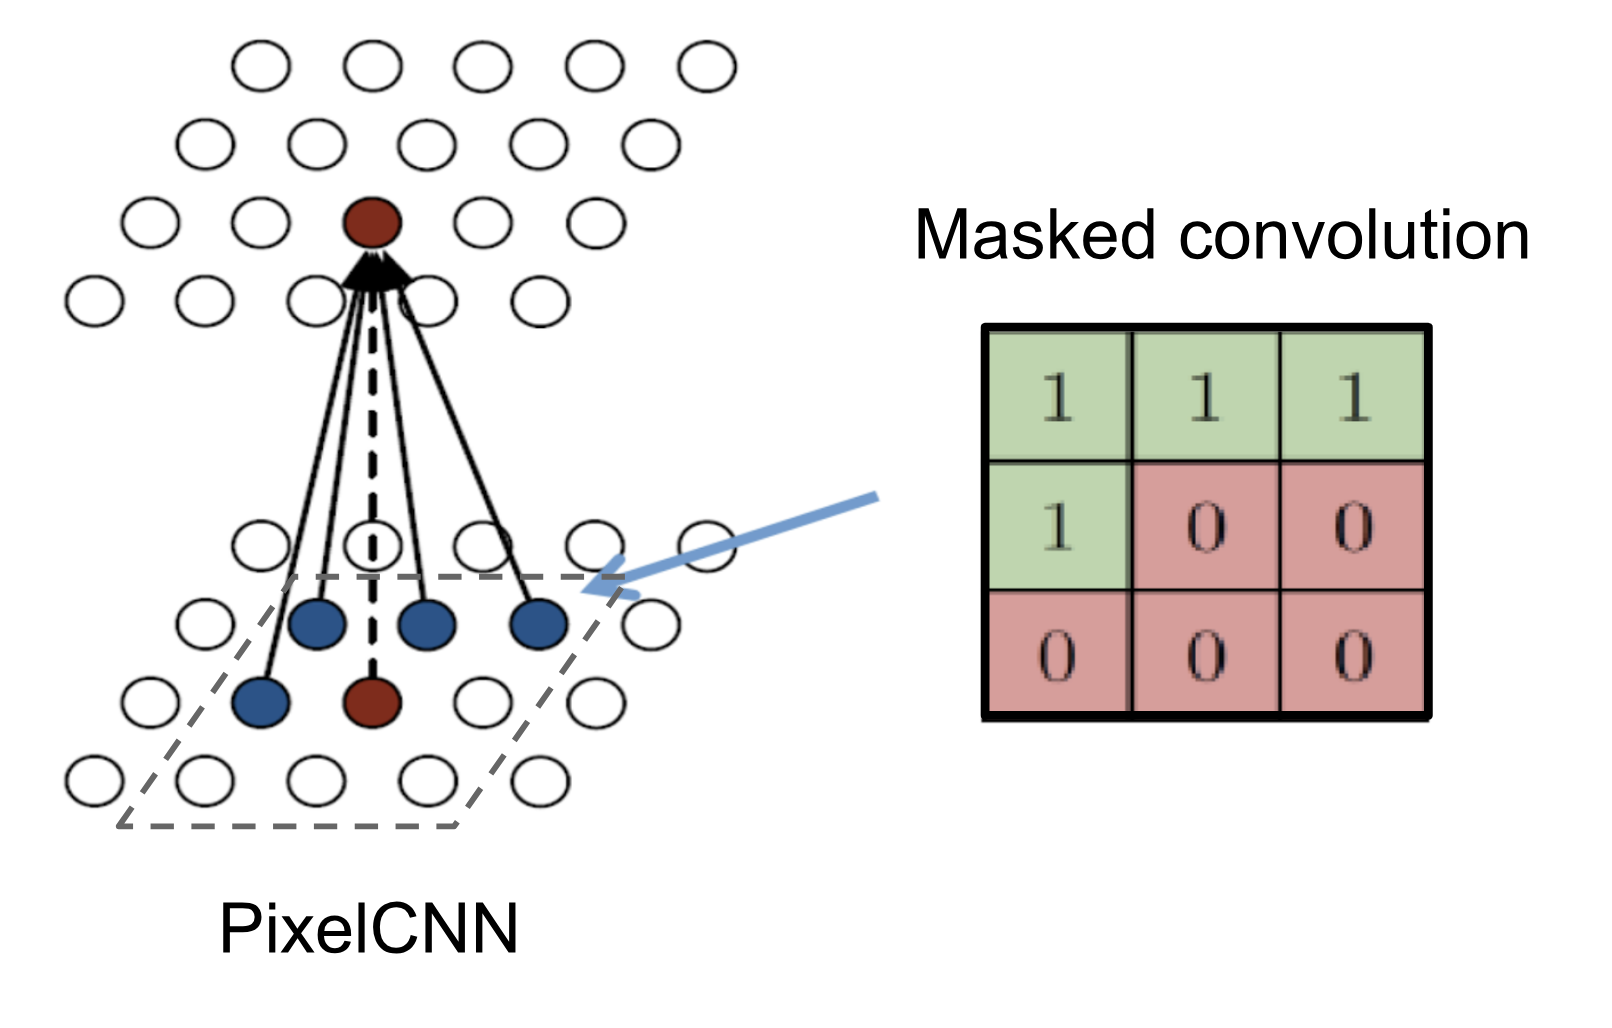

---

## III. Implémentation : PixelCNN Simplifié (PyTorch)

Nous allons entraîner un PixelCNN minimal sur MNIST.

---

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())  # Binarize the dataset
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 126kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.0MB/s]

Train Dataset Size: 60000
Test Dataset Size: 10000


### Define Masked Convolutions

In [2]:
import torch.nn as nn

class MaskedConv2d(nn.Conv2d):
    """
    Implements masked convolution as used in PixelCNN.
    Mask A: Masks out all pixels including the current pixel (used for the first layer).
    Mask B: Masks out all future pixels but includes the current pixel (used in other layers).
    """
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, padding):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, padding=padding)

        self.register_buffer('mask', torch.ones(out_channels, in_channels, kernel_size, kernel_size))
        center = kernel_size // 2

        for i in range(kernel_size):
            for j in range(kernel_size):
                if i > center or (i == center and j > center):
                    self.mask[:, :, i, j] = 0

        if mask_type == 'A':
            self.mask[:, :, center, center] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

Mask A: Used in the first layer, masks the current pixel and all future pixels.

Mask B: Used in subsequent layers, masks only future pixels.

### Build PixelCNN Model

In [3]:
class PixelCNN(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=64, kernel_size=7):
        super(PixelCNN, self).__init__()

        self.layers = nn.ModuleList()

        self.layers.append(MaskedConv2d('A', input_channels, hidden_channels, kernel_size, padding=kernel_size//2))

        for _ in range(6):
            self.layers.append(MaskedConv2d('B', hidden_channels, hidden_channels, kernel_size, padding=kernel_size//2))
            self.layers.append(nn.ReLU())

        self.layers.append(MaskedConv2d('B', hidden_channels, hidden_channels, kernel_size=1, padding=0))
        self.layers.append(nn.ReLU())
        self.layers.append(MaskedConv2d('B', hidden_channels, input_channels, kernel_size=1, padding=0))
        self.layers.append(nn.Sigmoid())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### Train the Model

Epoch 1/10, Train Loss: 0.1205, Test Loss: 0.0855
Epoch 2/10, Train Loss: 0.0843, Test Loss: 0.0821
Epoch 3/10, Train Loss: 0.0818, Test Loss: 0.0801
Epoch 4/10, Train Loss: 0.0803, Test Loss: 0.0789
Epoch 5/10, Train Loss: 0.0790, Test Loss: 0.0779
Epoch 6/10, Train Loss: 0.0781, Test Loss: 0.0772
Epoch 7/10, Train Loss: 0.0774, Test Loss: 0.0773
Epoch 8/10, Train Loss: 0.0767, Test Loss: 0.0762
Epoch 9/10, Train Loss: 0.0762, Test Loss: 0.0760
Epoch 10/10, Train Loss: 0.0757, Test Loss: 0.0762


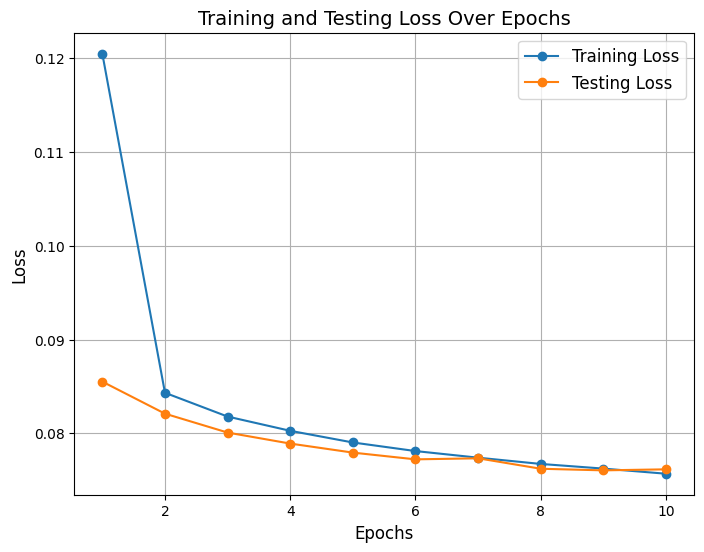

In [4]:
from torch.optim import Adam
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = PixelCNN().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

def train_pixelcnn(model, train_loader, test_loader, epochs=10):
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            images, _ = batch
            images = images.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                images, _ = batch
                images = images.to(device)
                output = model(images)
                loss = criterion(output, images)
                test_loss += loss.item()

        test_losses.append(test_loss / len(test_loader))
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    return train_losses, test_losses

train_losses, test_losses = train_pixelcnn(model, train_loader, test_loader)

def plot_loss_curves(train_losses, test_losses):
    """
    Plot training and testing loss curves over epochs.
    """
    plt.figure(figsize=(8, 6))
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, test_losses, label='Testing Loss', marker='o')

    plt.title('Training and Testing Loss Over Epochs', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_loss_curves(train_losses, test_losses)

### Generate Samples

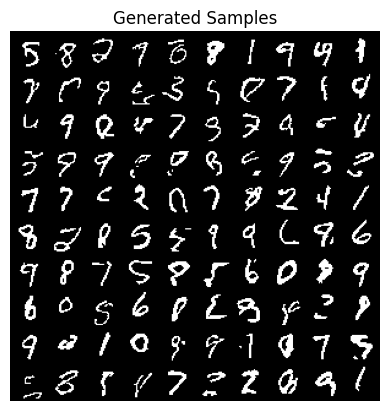

In [5]:
def generate_samples(model, num_samples=100, img_size=(28, 28)):
    model.eval()
    samples = torch.zeros((num_samples, 1, *img_size)).to(device)
    with torch.no_grad():
        for i in range(img_size[0]):
            for j in range(img_size[1]):
                out = model(samples)
                samples[:, :, i, j] = (torch.bernoulli(out[:, :, i, j])).detach()
    return samples

samples = generate_samples(model)
grid = torchvision.utils.make_grid(samples.cpu(), nrow=10)
plt.imshow(grid.permute(1, 2, 0))
plt.title("Generated Samples")
plt.axis('off')
plt.show()


## IV. Visualisation de la génération progressive (pixel par pixel)

Dans la section précédente, nous avons affiché **4 images finales** générées indépendamment par le modèle.

Ici, nous allons observer **la construction progressive d’une seule image** :
- au début : très peu de pixels fixés → image quasi noire  
- au milieu : des motifs commencent à apparaître  
- à la fin : image complète générée par le modèle  

L’objectif est de **visualiser le comportement autoregressif** :  
le modèle décide **un pixel à la fois**, en fonction de ceux déjà générés.

---

### 1. Génération d’une image avec "snapshots"

In [6]:
def generate_progressive(n=1):
    model.eval()
    samples = torch.zeros((n, 1, 28, 28)).to(device)

    snapshots = []   # pour stocker les versions intermédiaires

    for i in range(28):
        for j in range(28):
            with torch.no_grad():
                logits = model(samples)
                probs = logits[:, :, i, j]
                pixel = torch.bernoulli(probs)
                samples[:, :, i, j] = pixel

        # Sauvegarde d'un snapshot toutes les 4 lignes
        if i in [3, 7, 11, 15, 27]:
            snapshots.append(samples[0, 0].cpu().numpy())

    return snapshots


### 2. Affichage des étapes de génération

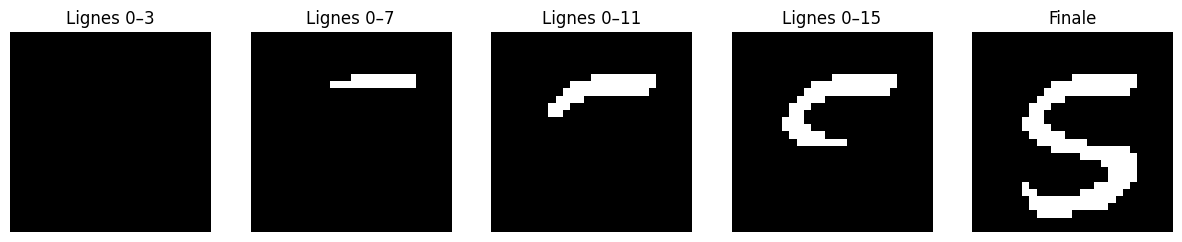

In [9]:
snapshots = generate_progressive()

titles = ["Lignes 0–3", "Lignes 0–7", "Lignes 0–11", "Lignes 0–15", "Finale"]

plt.figure(figsize=(15, 3))

for i, img in enumerate(snapshots):
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    plt.title(titles[i])
    plt.axis("off")

plt.show()


## Exercice : Application de PixelCNN à CIFAR-10 (ou autre dataset)

Choisissez **un dataset simple** parmi les suivants :

* Fashion-MNIST (1×28×28, vêtements),
* EMNIST (lettres),
* CIFAR-10 (3×32×32, si vous avez un GPU correct).

Réalisez les étapes suivantes :

1. Adaptez le code PixelCNN (architecture + transforms + loss).
2. Entraînez le modèle sur quelques epochs (5–10).
3. Générez au moins **8 images** et commentez :

   * les structures que le modèle a réussies à apprendre,
   * les limites visibles (flou, bruit, formes incomplètes),
   * la différence avec les résultats obtenus sur MNIST.

---

